## Оглавление
1. [Обзор и предобработка данных](#pre_processing)
2. [Оценка корректности проведения теста](#test_accuracy)
3. [Исследовательский анализ данных и оценка результатов А/В тестирования](#analysis)
4. [Общий вывод](#sumup)

**Оценка результатов A/B-теста**

На основании датасета с действиями пользователей, технического задания и вспомогательных датасетов необходимо:
- оценить корректность проведения теста,
- проанализировать результаты теста.

Для оценки корректности проведения теста, необходимо проверить:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Цель исследования** — проверить корректность проведения A/B-теста и дать оценку его результатам.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Ход исследования**

Перед анализом данных понадобится обзор и предобработка данных. Необходимо проверить данные на дубликаты, пропуски, аномалии и ошибки и оценить их влияние на исследование.

Таким образом, исследование пройдёт в пять этапов:

1. Обзор и предобработка данных
2. Оценка корректности проведения теста в следующих аспектах:
  - соответствие данных требованиям технического задания;
  - время проведения теста;
  - аудитория теста. 
3. Исследовательский анализ данных. 
- Мы изучим:
  - распределение количества событий на пользователя;
  - то, как число событий в выборках распределено по дням;
  - то, как меняется конверсия в воронке в выборках на разных этапах;
  - то, какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию.
- Оценим результаты A/B-тестирования и проверим статистической разницы долей z-критерием.
4. Общий вывод

## 1. Обзор и предобработка данных
<a name="pre_processing"></a>

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st
import datetime as dt
from datetime import datetime, timedelta
import warnings

In [232]:
warnings.filterwarnings("ignore")

In [233]:
# изучим данные о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
final_ab_events = pd.read_csv('final_ab_events.csv')
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [234]:
# посмотрим на общую информацию о таблице
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [235]:
# изменим тип данных для колонки с датой
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])


In [236]:
# проверим данные на пропуски
final_ab_events.isna().mean()

user_id       0.000000
event_dt      0.000000
event_name    0.000000
details       0.857512
dtype: float64

Почти 86% пропущенных значений в столбце details. В нем собраные дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах. По всей видимости, данных было собрано очень мало.

In [237]:
# проверим данные на явные дубликаты
final_ab_events.duplicated().sum()

0

In [238]:
# проверим данные на аномалии
final_ab_events.describe()

,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [239]:
# проверим столбец на аномалии
final_ab_events['user_id'].describe()

count               440317
unique               58703
top       A3917F81482141F2
freq                    36
Name: user_id, dtype: object

In [240]:
# проверим столбец на аномалии
final_ab_events['event_dt'].describe(datetime_is_numeric=True)

count                           440317
mean     2020-12-18 16:33:30.344980992
min                2020-12-07 00:00:33
25%                2020-12-14 06:38:31
50%                2020-12-19 02:14:36
75%                2020-12-22 23:47:03
max                2020-12-30 23:36:33
Name: event_dt, dtype: object

Согласно ТЗ в этой таблице присутствуют данные с 7 декабря 2020 по 4 января 2021 года. Однако по факту новые пользователи совершали действия только с 7 по 30 декабря 2020 года.

In [241]:
final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [242]:
# посчитаем, о каком количестве уникальных пользователях собраны данные в таблице
final_ab_events['user_id'].nunique()

58703

**Вывод**

Изучение таблицы данных о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года позволяет нам сделать следующие выводы:
- в dataframe 440317 строк и 4 столбца, нет явных дубликатов;
- в столбце `details` 86% пропущенных значений. В нем собраные дополнительные данные о событии. По всей видимости, данных было собрано очень мало;
- cогласно ТЗ в таблице присутствуют данные с 7 декабря 2020 по 4 января 2021 года. Однако по факту в ней собраны данные о действиях 58 703 пользователей только с 7 по 30 декабря 2020 года.

In [243]:
# изучим таблицу участников тестов
final_ab_participants = pd.read_csv('final_ab_participants.csv')
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [244]:
# получим общую информацию о таблице
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [245]:
# проверим данные на явные дубликаты
final_ab_participants.duplicated().sum()

0

In [246]:
final_ab_participants['group'].unique()

array(['A', 'B'], dtype=object)

In [247]:
# проверим данные на аномалии
final_ab_participants['user_id'] .describe()

count                18268
unique               16666
top       0FDFDA0B2DEC2D91
freq                     2
Name: user_id, dtype: object

В тестах участвовало 16 666 уникальных пользователей, а в таблице действий новых пользователей 58 703 уникальных пользователя. 

In [248]:
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В таблице с участниками теста смешаны участники двух тестов `recommender_system_test` и `interface_eu_test`. Проверим есть ли пересечение между участниками и посчитаем количество уникальных участников recommender_system_test теста.

In [249]:
display(final_ab_participants.groupby('ab_test').agg({'user_id':'nunique'}))
final_ab_participants.groupby('ab_test').agg({'user_id':'nunique'}).sum()

,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


user_id    18268
dtype: int64

В recommender_system_test участвовал 6701 участник. 

При разделении участников на разные тесты уникальное количество участников стало больше на 1602, значит участники двух тестов пересекаются. 

In [250]:
# сформируем список участников обоих тестов
interface_eu_test_participants = final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].unique()
recommender_system_test_participants = final_ab_participants.query('ab_test == "recommender_system_test"')['user_id'].unique()



In [251]:
# сформируем список тех пользователей, которые участвовали в обоих тестах сразу
final_ab_participants_both = final_ab_participants.query('user_id in @interface_eu_test_participants and user_id in @recommender_system_test_participants')

final_ab_participants_both['user_id'].nunique()



1602

1602 пользователя участвовали в двух тестах. Посмотрим, сколько пользователей из этого списка участвуют в группе В eu теста, т.е. взаимодействовали с изменениями.

In [252]:
final_ab_participants_both.pivot_table(index='ab_test', columns='group', aggfunc='nunique')

user_id     
group                         A    B
ab_test                             
interface_eu_test           819  783
recommender_system_test     921  681

783 человека из участников обоих тестов вошли в группу В eu теста.

Создадим списки таких участников.

In [253]:
eu_group_a = final_ab_participants_both.query('ab_test == "interface_eu_test" and group == "A"')['user_id'].unique()
eu_group_b = final_ab_participants_both.query('ab_test == "interface_eu_test" and group == "B"')['user_id'].unique()

rec_group_a = final_ab_participants_both.query('ab_test == "recommender_system_test" and group == "A"')['user_id'].unique()
rec_group_b = final_ab_participants_both.query('ab_test == "recommender_system_test" and group == "B"')['user_id'].unique()


Посмотрим, как пользователи из группы В второго теста распределены в группах А и В исследуемого теста, если их распределение одинаково, то мы можем говорить об одинаковом влиянии пользователей второго теста на наш тест, что не должно отразиться на основном результате - изменении конверсии в группе В по сравнению с группой А.

In [254]:
(
    final_ab_participants_both
.query('ab_test == "recommender_system_test" and user_id in @eu_group_b')
.groupby('group').agg({'user_id':'nunique'})
)

,user_id
group,
A,439
B,344


Распределение неравномерно. Значит нам стоит удалить пересекающихся участников из группы В eu теста, то есть на решения которых могли повлиять изменения eu теста.

In [255]:
# оставим только тех, участников, которые не участвовали в тесте группе В теста interface_eu_test
final_ab_participants_new = final_ab_participants.query('user_id not in @eu_group_b and ab_test == "recommender_system_test"')
final_ab_participants_new.groupby('ab_test').agg({'user_id':'nunique'})

,user_id
ab_test,
recommender_system_test,5918


Количество уникальных участников теста `recommender_system_test` после удаления пересекающихся участников стало 5918.

Посмотрим на распределение участников между группами.

In [256]:
group_users = final_ab_participants_new.groupby('group', as_index=False).agg({'user_id':'nunique'})
group_users

,group,user_id
0,A,3385
1,B,2533


In [257]:
# посчитаем относительную разницу между количеством пользователей в группах
group_users['user_id'][0]/group_users['user_id'][1] - 1

0.33636004737465464

Относительное различие количества пользователей равно 33%. Результаты могут быть очень сильно искажены.

**Вывод**

Изучение таблицы с данными об участниках тестов позволяет нам сделать следующие выводы:
- в таблице 18268 строки и 3 столбца, нет явных дубликатов и пропусков;
- в обоих тестах участвует 16 666 уникальных пользователей, 6701 - `recommender_system_test`;
- в таблице с участниками теста смешаны участники двух тестов `recommender_system_test` и `interface_eu_test`. После удаления участников группы В `interface_eu_test` теста осталось 5918 уникальных участников теста `recommender_system_test`, в то время как ожидаемое количество участников теста согласно ТЗ 6000 человек;
- после разделения участников теста по группам относительное различие количества пользователей в двух группах равно 33%. Из-за неравномерного разделения результаты могут быть очень сильно искажены. 

In [258]:
# изучим календарь маркетинговых событий на 2020 год
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')
ab_project_marketing_events.sort_values(by='finish_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


In [259]:
# изучим общую информацию о таблице
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [260]:
# изменим тип данных для столбцов с датой 
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

In [261]:
# проверим данные на явные дубликаты
ab_project_marketing_events.duplicated().sum()

0

In [262]:
# проверим данные на аномалии
ab_project_marketing_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [263]:
ab_project_marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [264]:
ab_project_marketing_events['start_dt'].describe()

count             14
unique            14
top       2020-12-25
freq               1
Name: start_dt, dtype: object

In [265]:
ab_project_marketing_events['finish_dt'].describe(datetime_is_numeric=True)

count                               14
mean     2020-07-02 06:51:25.714285824
min                2020-01-25 00:00:00
25%                2020-03-23 12:00:00
50%                2020-06-01 12:00:00
75%                2020-10-31 18:00:00
max                2020-12-30 00:00:00
Name: finish_dt, dtype: object

**Вывод**

Изучив календарь маркетинговых событий на 2020 год, мы делаем следующие выводы:
- в таблице 14 строк и 4 столбца, нет дубликатов и пропусков;
- маркетинговые кампании проводились с 25 января 2020 года по 7 января 2021 года;

  - Дата запуска теста: 7 декабря 2020 года.
  - Дата остановки набора новых пользователей: 21 декабря 2020 года.
- во время набора новых пользователей не проводились рекламные кампании, то есть маркетинговые активности не влияли на набор пользователей, однако кампания Christmas&New Year Promo началась 25 декабря 2020 года и могла косвенно повлиять на действия пользователей с 25 по 30 декабря 2020 года.

In [266]:
# изучим таблицу со списком пользователей, зарегистрировавшихся с 7 по 21 декабря 2020 года
final_ab_new_users = pd.read_csv('final_ab_new_users.csv')
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [267]:
# посмотрим на общую информацию о таблице
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [268]:
# изменим тип данных для столбца с датой
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format='%Y-%m-%d')
final_ab_new_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [269]:
# проверим данные на явные дубликаты
final_ab_new_users.duplicated().sum()

0

In [270]:
# проверим данные на аномалии
final_ab_new_users['first_date'].describe(datetime_is_numeric=True)

count                            61733
mean     2020-12-14 23:38:12.796397568
min                2020-12-07 00:00:00
25%                2020-12-11 00:00:00
50%                2020-12-15 00:00:00
75%                2020-12-20 00:00:00
max                2020-12-23 00:00:00
Name: first_date, dtype: object

In [271]:
final_ab_new_users['user_id'].describe()

count                61733
unique               61733
top       D72A72121175D8BE
freq                     1
Name: user_id, dtype: object

Согласно ТЗ в таблице представлены пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года. Однако в реальности представлены данные с 7 по 23 декабря 2020 года, за этот период  в системе зарегистрировалось 61733 новых пользователя.

In [272]:
final_ab_new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

Посмотрим на распределение по регионам участников, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

In [273]:
final_ab_new_users.query('first_date <= "2020-12-21"').groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,2883
CIS,2900
EU,42340
N.America,8347


С 7 по 21 декабря 2020 года в системе зарегистрировалось 42340 пользователей из Eu.

In [274]:
final_ab_new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

**Вывод**

Изучив таблицу с данными пользователей, зарегистрировавшихся с 7 по 21 декабря 2020 года, мы делаем следующие выводы:
- в таблице 61733 строки и 4 столбца, нет явных дубликатов и пропусков;
- с 7 по 21 декабря 2020 года в системе зарегистрировалось 42340 пользователей из Eu;
- согласно ТЗ в таблице представлены пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года. Однако в реальности представлены данные с 7 по 23 декабря 2020 года, за этот период в системе зарегистрировалось 61 733 новых пользователя.

## 2. Оценка корректности проведения теста
<a name="test_accuracy"></a>

Оценим соответствие данных требованиям технического задания.

- Название теста: `recommender_system_test`. 
  - **Комментарий**: в таблице с участниками теста смешаны участники двух тестов recommender_system_test и interface_eu_test;
- группы: А — контрольная, B — новая платёжная воронка. 
  - **Комментарий**: данные соответствуют;
- дата запуска: 2020-12-07. 
  - **Комментарий**: данные соответствут;
- дата остановки набора новых пользователей: 2020-12-21. 
  - **Комментарий**: представлены данные с 7 по 23 декабря 2020 года;
- дата остановки: 2021-01-04. 
  - **Комментарий**: cогласно ТЗ в таблице присутствуют данные с 7 декабря 2020 по 4 января 2021 года. Однако по факту в ней собраны данные о действиях 58 703 пользователей только с 7 по 30 декабря 2020 года;
- аудитория: 15% новых пользователей из региона EU. 
  - **Комментарий**: проверим далее;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. 
  - **Комментарий**: комментарий отсутствует, мало данных для проверки;
- ожидаемое количество участников теста: 6000. 
  - **Комментарий**: после удаления участников группы В interface_eu_test теста осталось 5918 уникальных участников теста recommender_system_test;
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%. 
  - **Комментарий**: проверим далее.

Оценим время проведения теста.

Во время набора новых пользователей не проводились рекламные кампании, то есть маркетинговые активности не влияли на набор пользователей, однако кампания Christmas&New Year Promo началась 25 декабря 2020 года и могла косвенно повлиять на действия пользователей с 25 по 30 декабря 2020 года.



Оценка равномерности распределения по тестовым группам показала, что после разделения участников теста по группам относительное различие количества пользователей в двух группах равно 33%. Из-за неравномерного разделения результаты могут быть очень сильно искажены. ёё

Проверим процент участников из Eu.

In [275]:
# проверим количество участников теста из региона EU до удаления пользователей

final_full = final_ab_participants.query('ab_test == "recommender_system_test"').merge(final_ab_events, on='user_id', how='left')
final_full = final_full.merge(final_ab_new_users, on='user_id', how='left')

final_full.groupby('region').agg({'user_id':'nunique'})


,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


Разделим количество участников теста из региона EU до удаления пользователей на количество всех новых пользователей их Европы, набранных за время набора в тест (до 21 декабря).

In [276]:
display(final_ab_new_users.query('first_date <= "2020-12-21"').groupby('region').agg({'user_id':'nunique'}))

6351/42340

,user_id
region,
APAC,2883
CIS,2900
EU,42340
N.America,8347


0.15

15% участников теста из региона EU.

Проверим наличие пользователей, участвующих в двух группах теста одновременно.

Создадим таблицу с финальными данными пользователей, которые участвовали в тесте `recommender_system_test`.

In [277]:
final = final_ab_participants_new.merge(final_ab_events, on='user_id', how='left')
final = final.merge(final_ab_new_users, on='user_id', how='left')

#добавим столбец с датой
final['purchase_date'] = final['event_dt'].dt.date
final['purchase_date'] = pd.to_datetime(final['purchase_date'])
final.head()

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,purchase_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC,2020-12-07


In [278]:
# проверим, есть ли пересечения по пользователям в разных группах
first = final.query('group == "A"').groupby('user_id', as_index=False).agg('nunique')
first = first['user_id']
second = final.query('group == "B"').groupby('user_id', as_index=False).agg('nunique')
second = second['user_id']

display(first.isin(second).unique())
display(second.isin(first).unique())

array([False])

array([False])

Пересечений нет.

Проверим на пропущенные значения.

In [279]:
final.isna().mean()

user_id          0.000000
group            0.000000
ab_test          0.000000
event_dt         0.109072
event_name       0.109072
details          0.880119
first_date       0.000000
region           0.000000
device           0.000000
purchase_date    0.109072
dtype: float64

Почти 11% пользователей из групп теста не совершали никаких событий.
Проверим, в каких они группах.

In [280]:
zero = final.groupby(['group', 'user_id']).agg({'event_dt':'count'}).sort_values(by='event_dt').reset_index()
zero.query('event_dt == 0').groupby('group').agg({'user_id':'count'})

,user_id
group,
A,963
B,1711


Пользователей из группы В, которые не совершали ни одного события, почти в 2 раза больше пользователей из группы А, не совершавших ни одного события.

Проверим дату регистрации пользователей из итоговой таблицы.

In [281]:
final['first_date'].describe(datetime_is_numeric=True)

count                            24516
mean     2020-12-14 23:06:54.096916224
min                2020-12-07 00:00:00
25%                2020-12-12 00:00:00
50%                2020-12-15 00:00:00
75%                2020-12-19 00:00:00
max                2020-12-21 00:00:00
Name: first_date, dtype: object

В итоговую таблицу попали пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года согласно ТЗ.

Проверим дату и время совершения действий.

In [282]:
final['event_dt'].describe(datetime_is_numeric=True)

count                            21842
mean     2020-12-18 23:44:45.625904128
min                2020-12-07 00:05:57
25%      2020-12-15 11:05:27.249999872
50%         2020-12-19 11:52:24.500000
75%                2020-12-22 15:11:55
max                2020-12-30 12:42:57
Name: event_dt, dtype: object

Действия пользователи производили с 7 до 30 декабря. 

Согласно ТЗ ожидается, что пользователи покажут улучшение каждой метрики не менее, чем на 10% за 14 дней с момента регистрации. В данном случае, горизонт событий составляет 14 дней, а значит мы можем оценить метрики только для пользователей, зарегистрировавшихся с 7 по 16 декабря. 


**Вывод**

Оценим соответствие данных требованиям технического задания.

- таблице с участниками теста смешаны участники двух тестов recommender_system_test и interface_eu_test;
- группы: А — контрольная, B — новая платёжная воронка согласно ТЗ;
- дата запуска: 2020-12-07 согласно ТЗ;
- согласно ТЗ дата остановки набора новых пользователей: 2020-12-21, однако представлены данные с 7 по 23 декабря 2020 года;
- cогласно ТЗ в таблице присутствуют данные с 7 декабря 2020 по 4 января 2021 года. Однако по факту в ней собраны данные о действиях 58 703 пользователей только с 7 по 30 декабря 2020 года;
- 15% новых пользователей из региона EU согласно ТЗ;
- после удаления участников interface_eu_test теста и пересекающихся участников двух тестов осталось 5099 уникальных участников теста recommender_system_test, а в ТЗ заявлено 6000;
- согласно ТЗ за 14 дней с момента регистрации от пользоватей ожидается улучшение каждой метрики не менее, чем на 10% за 14 дней с момента регистрации. В данном случае, горизонт событий составляет 14 дней, а значит мы можем оценить метрики только для пользователей, зарегистрировавшихся с 7 по 16 декабря;
- во время набора новых пользователей не проводились рекламные кампании, то есть маркетинговые активности не влияли на набор пользователей, однако кампания Christmas&New Year Promo началась 25 декабря 2020 года и могла косвенно повлиять на действия пользователей с 25 по 30 декабря 2020 года;
- после разделения участников теста по группам относительное различие количества пользователей в двух группах равно 33%. Из-за неравномерного разделения результаты могут быть очень сильно искажены. Если мы обнаружим ухудшение конверсии на 33%, скорее всего, тест неинформативен. Для качественного деления трафика сделовало провести A/A-тест, который помог бы измерить качество деления, определить доли групп, и подтвердить однородность трафика — отсутствие различия ключевых метрик между группами;
- пересечения участников между группами теста нет; 
- почти 11% пользователей из групп теста не совершали никаких событий, из которых почти 64% из группы В (это почти 68% участников группы В). Вероятная причина: некорректное распределение пользователей по группам, о чем также говорит относительное различие количества пользователей в двух группах в 33%.

## 3. Исследовательский анализ данных и оценка результатов А/В тестирования
<a name="analysis"></a>

Посмотрим, как меняется конверсия в воронке в выборках на разных этапах.

In [283]:
funnel_A = final.query('group == "A"').groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
funnel_A['conversion'] = funnel_A['user_id']/final.query('group == "A"')['user_id'].nunique()
funnel_A


,user_id,conversion
event_name,,
login,2422,0.715510
product_page,1571,0.464106
purchase,773,0.228360
product_cart,728,0.215066


In [284]:
funnel_B = final.query('group == "B"').groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
funnel_B['conversion'] = funnel_B['user_id']/final.query('group == "B"')['user_id'].nunique()
funnel_B

,user_id,conversion
event_name,,
login,822,0.324516
product_page,459,0.181208
purchase,226,0.089222
product_cart,225,0.088827


Корзину посмотрели меньше пользователей, чем тех, кто сделал покупку. 

Помимо этого, в группе В очень низкий уровень конверсии на всех этапах воронки.

Проверим, одинаково ли распредено количество событий на пользователя в разных группах.

In [285]:
final_A = final.query('group == "A"')
final_B = final.query('group == "B"')

display(len(final_A.query('event_dt != "NaT"'))/final_A['user_id'].nunique())
display(len(final_B.query('event_dt != "NaT"'))/final_B['user_id'].nunique())

5.066174298375184

1.852743782076589

В группе А приходится в среднем 5 событий на пользователя, а в В - 1,8.

Посмотрим, как количество событий на пользователя распределены на графике.

In [286]:
# посчитаем, сколько действий совершил каждый пользователь за 14 дней
final['fourteen'] = final['first_date']+timedelta(days=14)
by_user = (
    final.query('purchase_date != "NaT"')
    .groupby(['user_id','group']).agg({'first_date':'min', 'fourteen':'max','event_name':'count'})
    .sort_values(by='first_date')
)

by_user_A = by_user.query('group == "A"')
by_user_B = by_user.query('group == "B"')

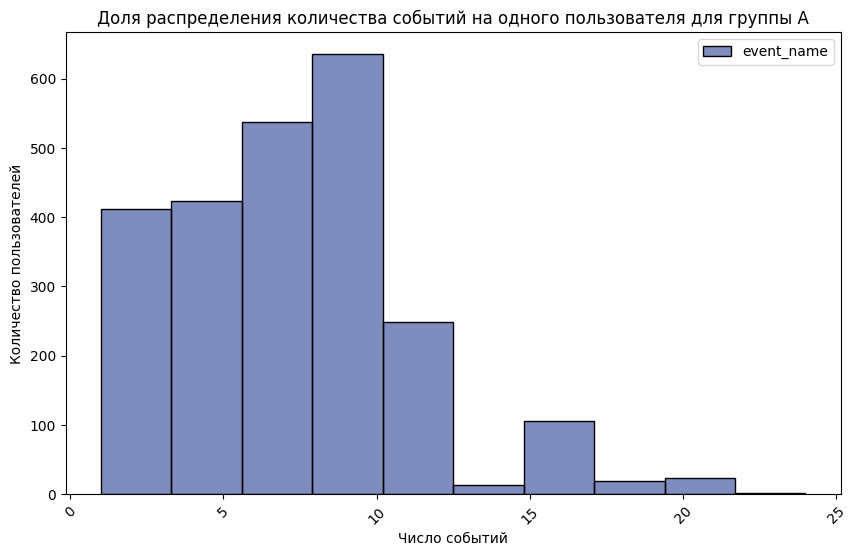

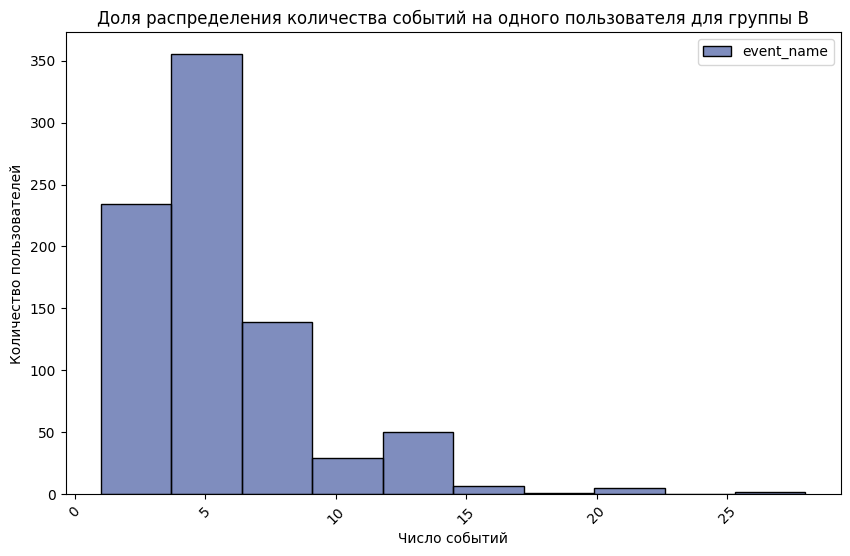

In [287]:
def by_user (group_data, group_name):
    plt.figure(figsize=(10, 6))
    sns.set_palette('dark')
    ax = sns.histplot(data=group_data, bins = 10)
    plt.xticks(rotation=45)
    ax.set_title('Доля распределения количества событий на одного пользователя для группы {}'.format(group_name)) 
    ax.set_xlabel('Число событий')
    ax.set_ylabel('Количество пользователей') 
    plt.show()
    
by_user(by_user_A, 'A')
by_user(by_user_B, 'B')

В группе А пользователи чаще всего совершали 8-10 событий, а в группе В - 5.

Посмотрим, как число событий в выборках распределено по дням.

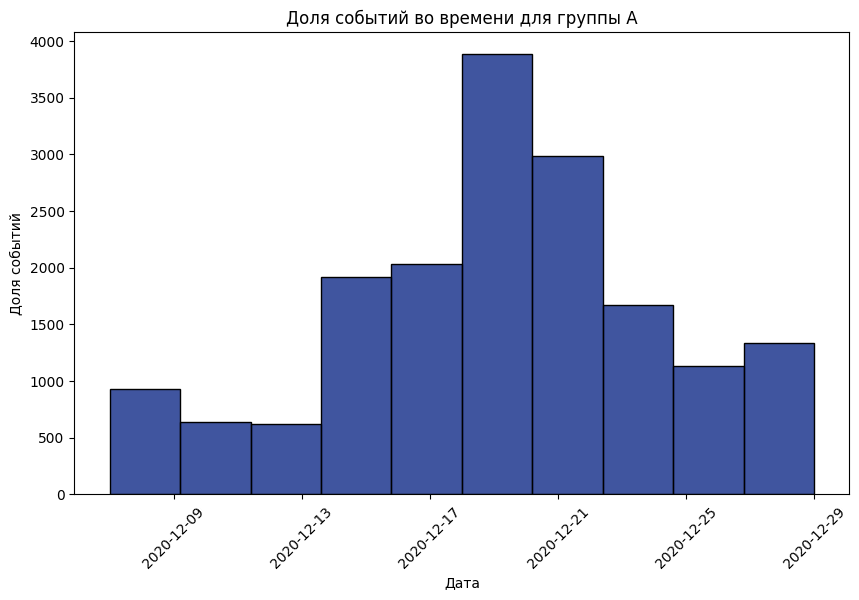

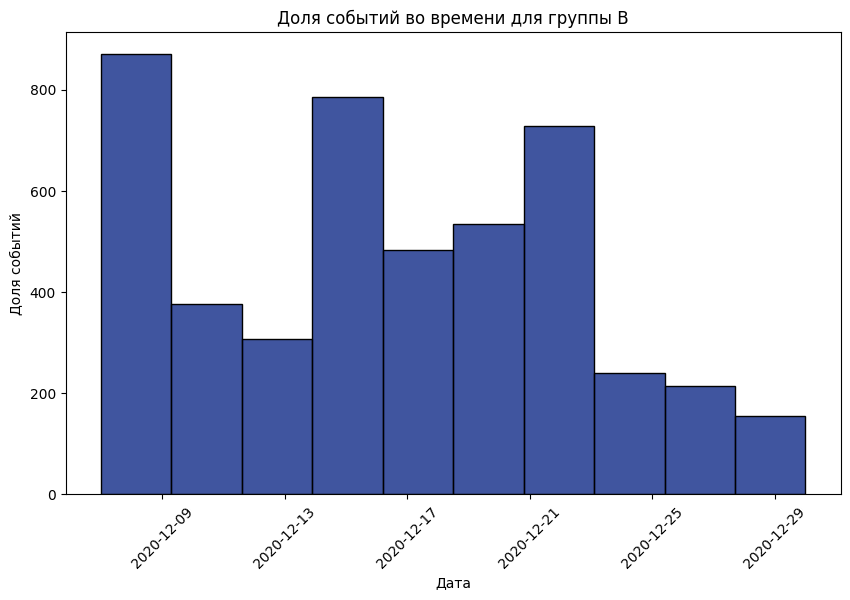

In [288]:
# построим график распределения объема событий во времени

def timelapse (group_data, group_name):
  plt.figure(
  figsize=(10, 6)
)
  sns.set_palette('dark')
  ax = sns.histplot(data=group_data['purchase_date'], bins = 10)
  plt.xticks(rotation=45)
  ax.set_title('Доля событий во времени для группы {}'.format(group_name)) 
  ax.set_xlabel('Дата')
  ax.set_ylabel('Доля событий') 
  plt.show()

timelapse(final_A, 'A')
timelapse(final_B, 'B')

До 14 декабря число событий в группе А было небольшим, затем произошел рост, а с 23 декабря снижение активности. Больше всего событий произошло 19 декабря.
Активность пользователей из группы В похожа начиная с 14 декабря, однако до этой даты, а особенно в первый день теста 7 декабря активность была очень высокой с небольшим спадом 10-13 декабря.


Проверим статистическую разницу долей z-критерием.

In [289]:
# создадим таблицу с количеством клиентов, совершивших каждое событие в каждой группе
group_events = (
    final.pivot_table(index='event_name', columns='group', values='user_id', aggfunc = 'nunique')
    .sort_values(by='A', ascending=False).reset_index()
)
display(group_events)


group,event_name,A,B
0,login,2422,822
1,product_page,1571,459
2,purchase,773,226
3,product_cart,728,225


In [290]:
# добавим фуекцию для оценки наличия статистически знчимых различий в конверсиях между двумя группами
def z_test(successes_sample_one, successes_sample_two, trials_sample_one, trials_sample_two):
    alpha = 0.05 # критический уровень статистической значимости
  
    successes = np.array([successes_sample_one, successes_sample_two])
    trials = np.array([trials_sample_one, trials_sample_two])
  
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
  
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
  
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
  
    # разница пропорций в датасетах
    difference = p1 - p2
  
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
      p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)  
  
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
  
    print('p-значение: ', p_value)
  
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между пропорциями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными'
    )


In [291]:
# все пользователи
all_users = final.groupby('group')['user_id'].nunique()


#создадим функцию для проверки данных воронки

def foo(group_a, group_b, funnel_data, all_users_data):
    for index, row in funnel_data.iterrows():
        event = row['event_name']
        group_a_data = row[group_a]
        group_b_data = row[group_b]
        conversion_a = round(row[group_a] / all_users[group_a], 2)
        conversion_b = round(row[group_b] / all_users[group_b], 2)
        display('Результат этапа {} для групп {} (кол-во пользователей: {}, конверсия: {}) и {} (кол-во пользователей: {}, конверсия: {}):'.format(event, group_a, group_a_data, conversion_a, group_b, group_b_data, conversion_b))
        z_test(row[group_a], row[group_b], all_users_data[group_a], all_users_data[group_b])


Проверим гипотезу о наличии статистически значимых различий в конверсиях между группами с помощью z-теста.

- Нулевая гипотеза: пропорции равны.
- Альтернативная гипотеза: пропорции не равны.

In [292]:
# сделаем проверку для групп
foo("A", "B", group_events, all_users)

'Результат этапа login для групп A (кол-во пользователей: 2422, конверсия: 0.72) и B (кол-во пользователей: 822, конверсия: 0.32):'

p-значение:  0.0
Отвергаем нулевую гипотезу: между пропорциями есть значимая разница


'Результат этапа product_page для групп A (кол-во пользователей: 1571, конверсия: 0.46) и B (кол-во пользователей: 459, конверсия: 0.18):'

p-значение:  0.0
Отвергаем нулевую гипотезу: между пропорциями есть значимая разница


'Результат этапа purchase для групп A (кол-во пользователей: 773, конверсия: 0.23) и B (кол-во пользователей: 226, конверсия: 0.09):'

p-значение:  0.0
Отвергаем нулевую гипотезу: между пропорциями есть значимая разница


'Результат этапа product_cart для групп A (кол-во пользователей: 728, конверсия: 0.22) и B (кол-во пользователей: 225, конверсия: 0.09):'

p-значение:  0.0
Отвергаем нулевую гипотезу: между пропорциями есть значимая разница


Имеется статистически значимое различие между пропорциями. 

Построим графики кумулятивной конверсии по дням по группам.

In [293]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = final.query('event_dt != "NaT"')[['purchase_date','group']].drop_duplicates()

actionsAggregated = datesGroups.apply(lambda x: final[np.logical_and(final['purchase_date'] <= x['purchase_date'], final['group'] == x['group'])]
.agg({'purchase_date' : 'max', 'group' : 'max', 'event_dt' : 'nunique', 'user_id' : 'nunique'}), axis=1).sort_values(by=['purchase_date','group'])


actionsAggregated.columns = ['purchase_date', 'group', 'actions', 'users']


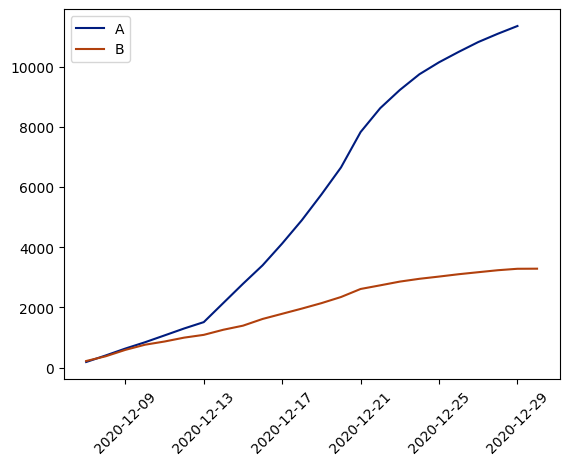

In [294]:
# датафрейм с кумулятивными данными пользователей в группе А
actionsAggregatedA = actionsAggregated[actionsAggregated['group']=='A']

# датафрейм с кумулятивными данными пользователей в группе B
actionsAggregatedB = actionsAggregated[actionsAggregated['group']=='B']

# Строим график количества действий пользователей группы А
plt.plot(actionsAggregatedA['purchase_date'], actionsAggregatedA['actions'], label='A')

# Строим график количества действий пользователей группы B
plt.plot(actionsAggregatedB['purchase_date'], actionsAggregatedB['actions'], label='B')
plt.xticks(rotation=45)
plt.legend()

Кумулятивное количество действий в группе А намного превышает данные группы В. 

Посчитаем кумулятивную конверсию.

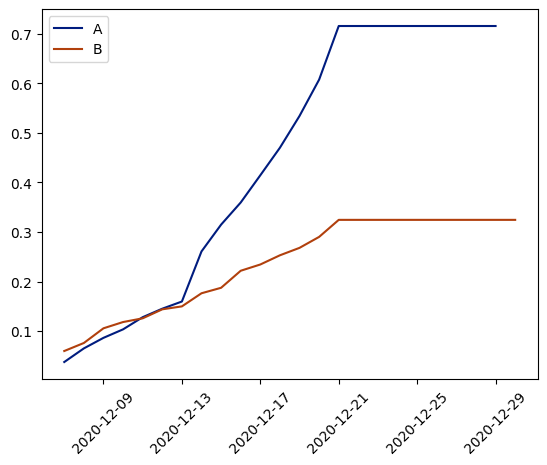

In [295]:
total_users_A = final.query('group == "A"')['user_id'].nunique()
total_users_B = final.query('group == "B"')['user_id'].nunique()

# считаем кумулятивную конверсию
actionsAggregatedA['conversion'] = actionsAggregatedA['users']/total_users_A
actionsAggregatedB['conversion'] = actionsAggregatedB['users']/total_users_B

# строим графики
plt.plot(actionsAggregatedA['purchase_date'], actionsAggregatedA['conversion'], label='A')
plt.plot(actionsAggregatedB['purchase_date'], actionsAggregatedB['conversion'], label='B')
plt.xticks(rotation=45)
plt.legend()


Начиная с 13 декабря кумулятивная коверсия группы А начала резко расти и достигла своего пика в 70% 21 декабря, после чего оставалась стабильной без повышения или понижения. Конверсия группы В также достигла плато в 30% 21 декабря.

(array([18605., 18609., 18613., 18617., 18621., 18625.]),
 [Text(18605.0, 0, '2020-12-09'),
  Text(18609.0, 0, '2020-12-13'),
  Text(18613.0, 0, '2020-12-17'),
  Text(18617.0, 0, '2020-12-21'),
  Text(18621.0, 0, '2020-12-25'),
  Text(18625.0, 0, '2020-12-29')])

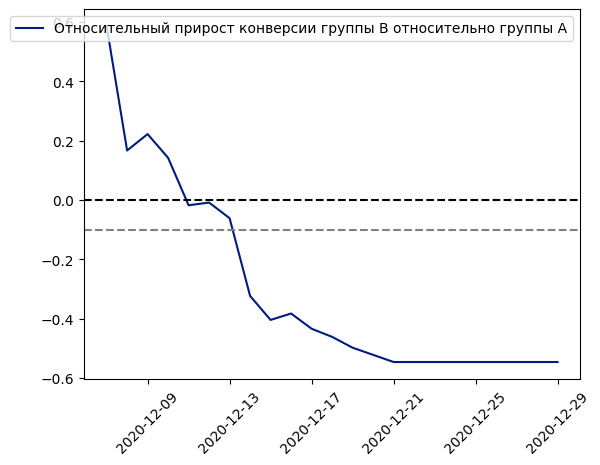

In [296]:
# Построим график относительного различия кумулятивных конверсий
mergedCumulativeConversions = actionsAggregatedA[['purchase_date','conversion']].merge(actionsAggregatedB[['purchase_date','conversion']], left_on='purchase_date', right_on='purchase_date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['purchase_date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=45)


В начале теста группа B выигрывала у группы A, потом её конверсия начала падать. Причем тенденция стабильна и можно сказать, что отношение конверсий установилось и группа В определенно проигрывает.

Однако стоит проанализировать аномалии. Может быть кто-то делает очень много действий.

In [297]:
# посчитаем среднее, медианное количество событий на пользователя, а также минимальное и максимальное количество событий
hey = final.groupby('user_id', as_index=False).agg({'event_dt':'count'})
display(hey['event_dt'].describe())

count    5918.000000
mean        3.690774
std         4.382431
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max        28.000000
Name: event_dt, dtype: float64

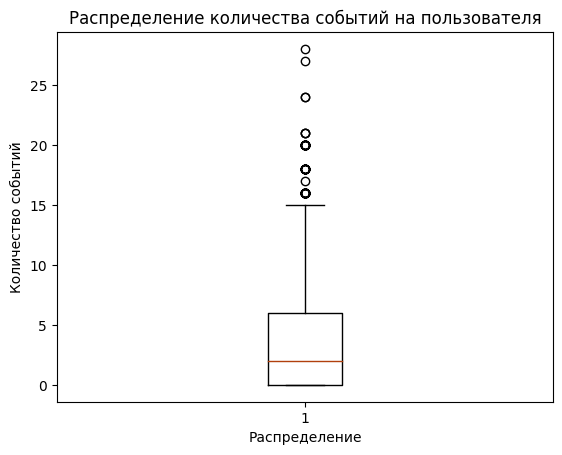

In [298]:
# посмотрим на распределение данных
plt.boxplot(hey['event_dt'])
plt.title("Распределение количества событий на пользователя")
plt.xlabel("Распределение")
plt.ylabel("Количество событий")
plt.show()

In [299]:
# посмотрим на выбросы
np.percentile(hey['event_dt'], [90, 95, 99])

array([10., 12., 16.])

Среднее количество действий 3,6, медианное - 2, максимальное - 28, при этом лишь 1% пользователей совершали больше 16 действий.

Выбросы не оказали существенного влияния на данные, можно сделать вывод о том, что конверсия группы В определенно проигрывает конверсии группы А.

**Вывод**

- в группе В очень низкий уровень конверсии на всех этапах воронки: login	32%, product_page	18%, purchase	9%, product_cart	8,8%;
- в группе А пользователи чаще всего совершали 8-10 событий, а в группе В - 5;
- до 14 декабря число событий в группе А было небольшим, затем произошел рост,а с 23 декабря снижение активности. Активность пользователей из группы В похожа начиная с 14 декабря, однако до этой даты, а особенно в первый день теста 7 декабря активность была очень высокой с небольшим спадом 10-13 декабря;
- z-тест показал, что имеется статистическая разница между пропорциями данных двух групп;
- кумулятивное количество действий в группе А намного превышает данные группы В;
- начиная с 13 декабря кумулятивная коверсия группы А начала резко расти и достигла своего пика в 70% 21 декабря, после чего оставалась стабильной без повышения или понижения. Конверсия группы В также достигла плато в 30% 21 декабря;
- график относительного различия кумулятивных конверсий показал, что отношение конверсий установилось и группа В определенно проигрывает;
- выбросы не оказали существенного влияния на данные, и можно сделать вывод о том, что конверсия группы В определенно проигрывает конверсии группы А.

## 4. Общий вывод
<a name="sumup"></a>

На основании датасета с действиями пользователей, технического задания и вспомогательных датасетов нам было необходимо оценить A/B-тест: проверить корректность проведения теста и проанализировать его результаты.

Перед анализом данных мы провели обзор и предобработку данных. Проверили данные на дубликаты, пропуски, аномалии и ошибки и оценили их влияние на исследование.

Для оценки корректности проведения теста мы проверили пересечение тестовой аудитории с конкурирующим тестом, совпадение теста и маркетинговых событий, другие проблемы временных границ теста. Также мы проверили соответствие данных требованиям технического задания, проанализировали время проведения теста и его аудиторию. После этого мы изучили распределение количества событий на пользователя, проверили, как число событий в выборках распределено по дням, как меняется конверсия в воронке в выборках на разных этапах, оценили результаты A/B-тестирования и проверили статистическую разницу долей z-критерием.

На основании проведенного анализа мы сделали следующие выводы:
- Соответствие ТЗ:
  - в таблице с участниками теста смешаны участники двух тестов recommender_system_test и interface_eu_test. После удаления участников группы В конкурирующего теста осталось 5918 уникальных участников, а в ТЗ заявлено 6000;
  - дата запуска: 2020-12-07 согласно ТЗ;
  - согласно ТЗ дата остановки набора новых пользователей: 2020-12-21, однако представлены данные с 7 по 23 декабря 2020 года;
  - cогласно ТЗ в таблице присутствуют данные с 7 декабря 2020 по 4 января 2021 года. Однако по факту в ней собраны данные о действиях 58 703 пользователей только с 7 по 30 декабря 2020 года;
  - 15% новых пользователей из региона EU согласно ТЗ;
  - согласно ТЗ за 14 дней с момента регистрации от пользоватей ожидается улучшение каждой метрики не менее, чем на 10% за 14 дней с момента регистрации. В данном случае горизонт событий составляет 14 дней, а значит мы сможем оценить метрики только для пользователей, зарегистрировавшихся с 7 по 16 декабря;
  - во время набора новых пользователей не проводились рекламные кампании, то есть маркетинговые активности не влияли на набор пользователей, однако кампания Christmas&New Year Promo началась 25 декабря 2020 года и могла косвенно повлиять на действия пользователей с 25 по 30 декабря 2020 года;
  - после разделения участников теста по группам относительное различие количества пользователей в двух группах равно 33%. Из-за неравномерного разделения результаты могут быть очень сильно искажены. Для качественного деления трафика следовало провести A/A-тест, который помог бы измерить качество деления, определить доли групп, и подтвердить однородность трафика;
  - пересечения участников между группами теста нет;
  - почти 11% пользователей из групп теста не совершали никаких событий, из которых почти 65% из группы В (это почти 68% участников группы В). Вероятная причина: некорректное распределение пользователей по группам, о чем также говорит относительное различие количества пользователей в двух группах в 33%.

- Оценка результатов теста:
  - в группе В очень низкий уровень конверсии на всех этапах воронки: login 32%, product_page 18%, purchase 9%, product_cart 8,8%;
  - в группе А пользователи чаще всего совершали 8-10 событий, а в группе В - 5;
  - до 14 декабря число событий в группе А было небольшим, затем произошел рост, а с 23 декабря снижение активности. Активность пользователей из группы В похожа начиная с 14 декабря, однако до этой даты, а особенно в первый день теста 7 декабря активность была очень высокой с небольшим спадом 10-13 декабря;
  - z-тест показал, что имеется статистическая разница между пропорциями данных двух групп;
  - кумулятивное количество действий в группе А намного превышает данные группы В;
  - начиная с 13 декабря кумулятивная коверсия группы А начала резко расти и достигла своего пика в 70% 21 декабря, после чего оставалась стабильной без повышения или понижения. Конверсия группы В также достигла плато в 30% 21 декабря;
  - график относительного различия кумулятивных конверсий показал, что отношение конверсий установилось и группа В определенно проигрывает;
  - выбросы не оказали существенного влияния на данные, и можно сделать вывод о том, что конверсия группы В определенно проигрывает конверсии группы А.

На основании проведенного анализа и сделанных выводов можно утверждать, что:
- Есть статистически значимое различие по конверсии между группами.
- График различия конверсии между группами сообщает, что результаты группы А лучше группы В.
- Количество событий на пользователя в группе А существенно выше группы В.
- В группе В очень низкий уровень конверсии на всех этапах воронки.

Однако стоит отметить следующие моменты:
- Некорректное деление пользователей между группами, что привело к количественному различию между ними и, вероятно, к отсутствию активности 68% участников группы В. Для качественного деления трафика следовало провести A/A-тест, который помог бы измерить качество деления, определить доли групп, и подтвердить однородность трафика.
- Смешение участников двух тестов. Участие пользователей в нескольких тестах одновременно могло повлиять на чистоту результата для всех тестов. 

Учитывая вышеизложенное, можно признать тест неуспешным.